In [1]:
import os, random, re
import torch
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm

from scipy.stats import entropy, norm, ttest_ind
from torch.utils.data import DataLoader, SubsetRandomSampler
from baseline.UNet3D import UNet3D, Encoder, Decoder
from baseline.datasets import lits17, brats20, kits21

In [2]:
%matplotlib inline  
%config InlineBackend.figure_format='retina'
# matplotlib.use('Agg')                        # uncomment to not rpint the seg. and uncertainty map visualisations on the notebook and save only into the PNG_DIR

## Compute and save the inference results from individual models as `numpy` arrays

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TTD_K = 50 # Test-time dropout sampling # (epistemic uncertainty)
TTA_K = 50 # number of MC sampling for approx. Gaussian logits before softmax (aleatoric uncertainty)

mkdir = lambda path : None if os.path.exists(path) else os.makedirs(path)

In [43]:
# run inference and save results as numpy arrays
root_dir = os.getcwd()                    # /root/
ood_dir = os.path.join(root_dir,'ood')
mkdir(ood_dir)                            # /root/ood/
NUMPY_DIR = os.path.join(ood_dir,'np')
mkdir(NUMPY_DIR)                          # /root/ood/np/
PNG_DIR = os.path.join(ood_dir,'png') 
mkdir(PNG_DIR)                            # /root/ood/png/

In [4]:
tasks = [
    {
        'name': 'lits17',
        'dataset': lits17,
        'in_channels': 1,
        'n_classes': 2,
        'enabled': True,
    },
    {
        'name': 'brats20',
        'dataset': brats20,
        'in_channels': 4,
        'n_classes': 2,
        'enabled': True,
    },
    {
        'name': 'kits21',
        'dataset': kits21,
        'in_channels': 1,
        'n_classes': 2,
        'enabled': True,
    }
]

In [5]:
fgsm_path = '/scratch/ec2684/cv/runs/fgsm'

fgsms = [
    {
        'run_path': 'Dec12_15-22-45_gr015.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_1_step_208_encoder.pth',
            'decoder_mean':'lits17_epoch_1_epoch_1_loss_0.08189_decoder_mean.pth',
            'decoder_var':'lits17_epoch_1_epoch_1_loss_0.08189_decoder_var.pth',
        },
    },
    {
        'run_path': 'Dec13_05-29-22_gr022.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_2_step_312_encoder.pth',
            'decoder_mean':'lits17_epoch_2_epoch_2_loss_0.08543_decoder_mean.pth',
            'decoder_var':'lits17_epoch_2_epoch_2_loss_0.08543_decoder_var.pth',
        },
    },
    {
        'run_path': 'Dec13_05-38-57_gr010.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_3_step_416_encoder.pth',
            'decoder_mean':'lits17_epoch_3_epoch_3_loss_0.09303_decoder_mean.pth',
            'decoder_var':'lits17_epoch_3_epoch_3_loss_0.09303_decoder_var.pth',
        },
    },
    {
        'run_path': 'Dec13_09-17-20_gr012.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_2_step_312_encoder.pth',
            'decoder_mean':'lits17_epoch_2_epoch_2_loss_0.07835_decoder_mean.pth',
            'decoder_var':'lits17_epoch_2_epoch_2_loss_0.07835_decoder_var.pth',
        },
    },
    {
        'run_path': 'Dec14_02-27-43_gr015.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_2_step_312_encoder.pth',
            'decoder_mean':'lits17_epoch_2_epoch_2_loss_0.09158_decoder_mean.pth',
            'decoder_var':'lits17_epoch_2_epoch_2_loss_0.09158_decoder_var.pth',
        },
    },
    {
        'run_path': 'Dec13_14-10-30_gr020.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_2_step_312_encoder.pth',
            'decoder_mean':'lits17_epoch_2_epoch_2_loss_0.07634_decoder_mean.pth',
            'decoder_var':'lits17_epoch_2_epoch_2_loss_0.07634_decoder_var.pth',
        },
    },
    {
        'run_path': 'Dec14_04-15-04_gr027.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_4_step_520_encoder.pth',
            'decoder_mean':'lits17_epoch_4_epoch_4_loss_0.06955_decoder_mean.pth',
            'decoder_var':'lits17_epoch_4_epoch_4_loss_0.06955_decoder_var.pth',
        },
    },
    {
        'run_path': 'Dec14_10-24-49_gr033.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_3_step_416_encoder.pth',
            'decoder_mean':'lits17_epoch_3_epoch_3_loss_0.06723_decoder_mean.pth',
            'decoder_var':'lits17_epoch_3_epoch_3_loss_0.06723_decoder_var.pth',
        },
    },
    {
        'run_path': './../Dec14_20-04-21_gr010.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_2_step_312_encoder.pth',
            'decoder_mean':'lits17_epoch_2_epoch_2_loss_0.08219_decoder_mean.pth',
            'decoder_var':'lits17_epoch_2_epoch_2_loss_0.08219_decoder_var.pth',
        },
    },
    {
        'run_path': './../Dec14_20-06-27_gr010.nyu.cluster_brats20_baseline_lr1.0e-04_weightDecay1.0e-02_fgsm1.0e-02',
        'model': {
            'encoder':'lits17_epoch_5_step_624_encoder.pth',
            'decoder_mean':'lits17_epoch_5_epoch_5_loss_0.06375_decoder_mean.pth',
            'decoder_var':'lits17_epoch_5_epoch_5_loss_0.06375_decoder_var.pth',
        },
    },
]

In [6]:
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
            
def forward(encoder, decoder_mean, decoder_var, x):
    out, context_1, context_2, context_3, context_4 = encoder(x)
    mean = decoder_mean(out, context_1, context_2, context_3, context_4)
    var = decoder_var(out, context_1, context_2, context_3, context_4)
    return mean, var

def predict(encoder, decoder_mean, decoder_var, x, T=10):
    mean, var = forward(encoder, decoder_mean, decoder_var, x)
    running_x = torch.zeros(var.shape).to(x.device)
    noise = torch.randn(var.shape).to(x.device)
    for i in tqdm(range(T), desc="Predicting TTA"):
        x = mean + var * noise
        running_x += torch.softmax(x, dim=1)
    return running_x / T

In [7]:
# load datasets (tasks)
task_list = []

for task in tasks:
    SEED = 42
    TRAIN_VAL_SPLIT = 0.8  # 80% training

    n = len(task['dataset'])
    idxrange = np.arange(n)
    rng = np.random.RandomState(SEED)
    rng.shuffle(idxrange)
    n_train = int(n * TRAIN_VAL_SPLIT)
    task['val_idx'] = idxrange[n_train:]

    task['val_dataloader'] = DataLoader(
        task['dataset'],
        batch_size=1,
        sampler=SubsetRandomSampler(task['val_idx']),
        num_workers=1,
    )
    task_list.append(task)

In [9]:
## ONLY RUN THIS IF YOU PLAN TO DO INFERNECE ##
## Note: make sure you have CUDA available ##

# load models
encoders = []
mean_decoders = []
var_decoders = []

for i, fgsm in enumerate(tqdm(fgsms)):
    # get model path
    model_path = os.path.join(fgsm_path,fgsm['run_path'])
    
    # instantiate model objects
    encoder = Encoder(task['in_channels']).to(device)
    decoder_mean = Decoder(task['in_channels'],task['n_classes']).to(device)
    decoder_var = Decoder(task['in_channels'],task['n_classes']).to(device)
    
    # load model trained models
    encoder.load_state_dict(torch.load(os.path.join(model_path,fgsm['model']['encoder'])))
    decoder_mean.load_state_dict(torch.load(os.path.join(model_path,fgsm['model']['decoder_mean'])))
    decoder_var.load_state_dict(torch.load(os.path.join(model_path,fgsm['model']['decoder_var'])))
    
    # ensure params. are set to CUDA
    assert next(encoder.parameters()).is_cuda == True
    assert next(decoder_mean.parameters()).is_cuda == True
    assert next(decoder_var.parameters()).is_cuda == True
    
    # inference mode
    encoder.eval();
    decoder_mean.eval();
    decoder_var.eval();

    # enable test-time dropout
    enable_dropout(encoder)
    enable_dropout(decoder_mean)
    enable_dropout(decoder_var)
    
    # append loaded models to a list
    encoders.append(encoder)
    mean_decoders.append(decoder_mean)
    var_decoders.append(decoder_var)

In [9]:
'''
numpy files will be saved under: /root/ood/np/[dataset]/preds/

file names will be in the following format:

(1) TTD and TTA prediction values:
'm[model_index]_[data_index]_[data_type].npy'
 - model_index(int): [1-10]
 - data_index (int): [0-len(val_dataset)]
 - data_type (str) : {'ttd','tta'} (ttd and tta are softmax values)

(2) Volume and segmentation data files:
'[data_index]_[data_type].npy'
 - data_index (int): [0-len(val_dataset)]
 - data_type (str) : { 'vol','seg'}
''';

In [10]:
filename_uq = lambda model_index, data_index, data_type : 'm'+str(1+model_index)+'_'+str(data_index)+'_'+str(data_type)
filename_data = lambda data_index, data_type : str(data_index)+'_'+str(data_type)

In [188]:
## ONLY RUN THIS IF YOU PLAN TO DO INFERNECE ##
## Note: this cell must be executed at least once for the remaining cells to compile ##
## if done so before, you can skip this cell to save time ##

# compute the ttd and tta (softmax) values and corresponding epistemic and aleatoric uncertainties for every
# model across lits, brats, kits validation samples and save them as numpy files.
for task in task_list:
    print(task['name'])
    dataset_path = os.path.join(NUMPY_DIR,str(task['name']))
    mkdir(dataset_path)                   # /root/ood/np/[dataset]/
    cur_path = os.path.join(dataset_path,'preds')
    mkdir(cur_path)                       # /root/ood/np/[dataset]/preds/
    
    with torch.no_grad():
        for data_index, (vol, seg) in enumerate(tqdm(task['val_dataloader'])):
            vol = vol.to(device)
            seg = seg.to(device)
            for model_index, (encoder, decoder_mean, decoder_var) in enumerate(zip(encoders,mean_decoders,var_decoders)):
                
                # Epsistemic uncertainty using test-time dropout
                running_mean_ttd = np.zeros(seg.shape)
                for _ in tqdm(range(TTD_K), desc=f"Data:{data_index} / Model:{model_index}: Predicting TTD"):
                    out, context_1, context_2, context_3, context_4 = encoder(vol)
                    mean = decoder_mean(out, context_1, context_2, context_3, context_4)
                    running_mean_ttd = running_mean_ttd + torch.softmax(mean,dim=1).cpu().numpy()
                ttd = running_mean_ttd / TTD_K
                
                # Aleatoric uncertainty
                tta = predict(encoder, decoder_mean, decoder_var, vol, T=TTA_K)
                
                np.save(os.path.join(cur_path,filename_uq(model_index,data_index,'ttd')), ttd[0,...])
                np.save(os.path.join(cur_path,filename_uq(model_index,data_index,'tta')), tta.cpu().numpy()[0,...])
                
            np.save(os.path.join(cur_path, filename_data(data_index,'vol')), vol.cpu().numpy()[0,0,...])
            np.save(os.path.join(cur_path, filename_data(data_index,'seg')), seg.cpu().numpy()[0,0,...])

## Compute the ensemble results from the previous model inference results for O.O.D. experiment

In [11]:
'''
data_dict[dataset][data_index][data_type][model_index]

dataset (str) : {'brats','kits','lits'}
data_index (int) : [0,...,len(val_data)]
data_type (str) : {'vol','seg','ttd','tta'} (ttd and tta are softmax values)
model_index (int) : [0,...,9]
''';

In [12]:
def load_data_to_dictionaries(path):
    """
    output dictionaries that record the input file paths
    """
    data = {}
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            splits = filename.split('_')
            nums = re.findall(r'\d+', filename)
            data_idx = int(nums[0])
            if(len(splits) > 2):
                model_idx = int(nums[1])
            data_type = splits[1].split('.')[0] if len(splits) == 2 else splits[2].split('.')[0]
            
            if data_idx not in list(data.keys()):
                data[data_idx] = {data_type: os.path.join(dirname, filename) if (len(splits) == 2) else {model_idx: os.path.join(dirname, filename)}}
            elif data_type not in list(data[data_idx].keys()):
                data[data_idx][data_type] = os.path.join(dirname, filename) if (len(splits) == 2) else {model_idx: os.path.join(dirname, filename)}
            else:
                data[data_idx][data_type].update(os.path.join(dirname, filename) if (len(splits) == 2) else {model_idx: os.path.join(dirname, filename)})
    return data

In [47]:
def get_dataset_path(dataset_name):
    return os.path.join(NUMPY_DIR,dataset_name)

In [48]:
get_dataset_path('lits17')

'/scratch/ec2684/cv/nyu-cv2271-final-main/ood/np/lits17'

In [49]:
data_dict = {}

for task in task_list:
    cur_path = os.path.join(get_dataset_path(task['name']),'preds')
    data_dict[task['name']] = load_data_to_dictionaries(cur_path)
    mkdir(os.path.join(get_dataset_path(task['name']),'ensemble'))

In [15]:
## ONLY RUN THIS IF YOU PLAN TO COMPUTE ENSEMBLE RESULTS ##
## Note: this cell must be executed at least once for the remaining cells to compile ##
## if done so before, you can skip this cell to save time ##

# calculating ensemble outputs.

for dataset_name in data_dict.keys():
    print(dataset_name)
    cur_dir = os.path.join(get_path(dataset_name),'ensemble')
    data_index = sorted(data_dict[dataset_name].keys())
    
    for index, sample in enumerate(tqdm(data_index)):
        
        ttd_samples = lambda i : data_dict[dataset_name][i]['ttd'][sample]
        tta_samples = lambda i : data_dict[dataset_name][i]['tta'][sample]
        
        ttd_running_mean = np.zeros(np.load(ttd_samples(1)).shape)
        tta_running_mean = np.zeros(np.load(tta_samples(1)).shape)
        
        for i in range(1,len(fgsms)+1):
            ttd_running_mean = ttd_running_mean + (1/(i))*(np.load(ttd_samples(i)) - ttd_running_mean)
            tta_running_mean = tta_running_mean + (1/(i))*(np.load(tta_samples(i)) - tta_running_mean)
            
            ttd_file_name = 'd'+str(sample)+'_e'+str(i)+'_ttd.npy'
            tta_file_name = 'd'+str(sample)+'_e'+str(i)+'_tta.npy'
            
            ttd_file_path = os.path.join(cur_dir,ttd_file_name)
            tta_file_path = os.path.join(cur_dir,tta_file_name)
            
            np.save(ttd_file_path, ttd_running_mean)
            np.save(tta_file_path, tta_running_mean)

In [15]:
'''
d[data_index]_e[#_of_ensemble]_[data_type].npy
''';

In [50]:
# Adding the ensemble numpy files to data dictionary

for task in task_list:
    cur_path = os.path.join(get_path(task['name']),'ensemble')
    for file_name in next(os.walk(cur_path))[2]:
        
        nums = re.findall(r'\d+', file_name)
        data_index = int(nums[0]) # data_index
        ensemble_m = int(nums[1]) # M
        uncertainty_type = file_name.split('_')[2].split('.')[0] # tta or ttd
        
        if 'ensemble' not in list(data_dict[task['name']][data_index].keys()):
            if uncertainty_type == 'tta':
                data_dict[task['name']][data_index]['ensemble'] = {ensemble_m: {'tta': os.path.join(cur_path,file_name)}}
            else:
                data_dict[task['name']][data_index]['ensemble'] = {ensemble_m: {'ttd': os.path.join(cur_path,file_name)}}
        elif ensemble_m not in list(data_dict[task['name']][data_index]['ensemble'].keys()):
            if uncertainty_type == 'tta':
                data_dict[task['name']][data_index]['ensemble'][ensemble_m] = {'tta': os.path.join(cur_path,file_name)}
            else:
                data_dict[task['name']][data_index]['ensemble'][ensemble_m] = {'ttd': os.path.join(cur_path,file_name)}
        else:
            if uncertainty_type == 'tta':
                data_dict[task['name']][data_index]['ensemble'][ensemble_m].update({'tta': os.path.join(cur_path,file_name)})
            else:
                data_dict[task['name']][data_index]['ensemble'][ensemble_m].update({'ttd': os.path.join(cur_path,file_name)})

In [51]:
ensemble = True

for dataset in data_dict.keys():
    for data_index in sorted(data_dict[dataset].keys()):
        ensemble = (sorted(list(data_dict[dataset][data_index]['ensemble'].keys())) == list(range(1,11))) and ensemble

print(ensemble)

True


In [18]:
'''
data_dict[dataset][data_index][data_type][model_index] or
data_dict[dataset][data_index][data_type][ensemble_m]

dataset (str) : {'brats','kits','lits'}
data_index (int) : [0,...,len(val_data)]
data_type (str) : {'vol','seg','ttd','tta','ensemble'} (ttd and tta are softmax values)
if data_type == 'ensemble':
    uncertainty type (str) : {'tta', 'ttd'}

- if data_type == ensemble:
ensemble_m (int) : [1,...,10]

- else:
model_index (int) : [0,...,9]
''';

In [19]:
'''
ood_ttd_tta[dataset][unertainty][sample_index][N_avg]

- dataset (str) : {'brats','kits','lits'}
- unertainty (str) : {'ttd','tta'}
- sample_index (int) : [0,...,9]
- N_avg (int) : [1,...,10]
''';

In [20]:
def get_ood_samples(dataset: str, ensemble_m: int , str_idx: int, end_idx: int):
    assert dataset in data_dict.keys(), f"Non existing dataset. Try one of the followings: {list(data_dict.keys())}"
    assert 0 <= str_idx and str_idx < len(data_dict[dataset].keys()), f"Starting index out of bounds for {dataset}."
    assert 0 <= end_idx and end_idx < len(data_dict[dataset].keys()), f"Ending index out of bounds for {dataset}."
    assert str_idx <= end_idx, f"Ending index needs to be greater than or equal to the starting index."
    max_m = len(data_dict[dataset][str_idx]['ensemble'].keys())
    assert 1 <= ensemble_m and ensemble_m <= max_m, f"Ensemble models available upto {max_m}."
    
    ood_tta = []
    ood_ttd = []
    
    for i in range(str_idx, end_idx+1):
        
        tta = np.load(data_dict[dataset][i]['ensemble'][ensemble_m]['tta'])
        ttd = np.load(data_dict[dataset][i]['ensemble'][ensemble_m]['ttd'])
        
        tta_seg_foreground_mask = (torch.argmax(torch.tensor(tta), dim=0) > 0).numpy()
        N_tta = np.count_nonzero(tta_seg_foreground_mask)
                                   
        ttd_seg_foreground_mask = (torch.argmax(torch.tensor(ttd), dim=0) > 0).numpy()
        N_ttd = np.count_nonzero(ttd_seg_foreground_mask)
        
        ood_tta.append((1./N_tta)*np.sum(entropy(tta, axis=0)*tta_seg_foreground_mask))
        ood_ttd.append((1./N_ttd)*np.sum(entropy(ttd, axis=0)*ttd_seg_foreground_mask))
        
    return ood_tta, ood_ttd

## Computing and plotting ood results:

In [21]:
get_ttest = lambda c, t : ttest_ind(np.array(c),np.array(t),equal_var = False)

In [22]:
def robust_ttest(data1, data2 = None, N = 1000, num_sample = 20):
    pval = 0.0
    if data2 == None:
        assert num_sample % 2 == 0, "num_sample has to be even."
        split = num_sample // 2
        for i in range(N):
            sample1 = random.sample(data1, num_sample)
            _, cur_pval = get_ttest(sample1[:split],sample1[split:])
            pval = pval + cur_pval
    else:
        assert num_sample < len(data1) and num_sample < len(data2), "num_sample is too large."
        for i in range(N):
            sample1 = random.sample(data1, num_sample)
            sample2 = random.sample(data2, num_sample)
            _, cur_pval = get_ttest(sample1,sample2)
            pval = pval + cur_pval

    pval = pval / N
    return pval

In [23]:
def get_ood_samples(dataset: str, ensemble_m: int , str_idx: int, end_idx: int):
    assert dataset in data_dict.keys(), f"Non existing dataset. Try one of the followings: {list(data_dict.keys())}"
    assert 0 <= str_idx and str_idx < len(data_dict[dataset].keys()), f"Starting index out of bounds for {dataset}."
    assert 0 <= end_idx and end_idx < len(data_dict[dataset].keys()), f"Ending index out of bounds for {dataset}."
    assert str_idx <= end_idx, f"Ending index needs to be greater than or equal to the starting index."
    max_m = len(data_dict[dataset][str_idx]['ensemble'].keys())
    assert 1 <= ensemble_m and ensemble_m <= max_m, f"Ensemble models available upto {max_m}."
    
    ood_tta = []
    ood_ttd = []
    
    excluded = {'tta':[],'ttd':[]}
    
    for i in range(str_idx, end_idx+1):
        
        tta = np.load(data_dict[dataset][i]['ensemble'][ensemble_m]['tta'])
        ttd = np.load(data_dict[dataset][i]['ensemble'][ensemble_m]['ttd'])
        
        tta_seg_foreground_mask = (torch.argmax(torch.tensor(tta), dim=0) > 0).numpy()
        N_tta = np.count_nonzero(tta_seg_foreground_mask)

                                   
        ttd_seg_foreground_mask = (torch.argmax(torch.tensor(ttd), dim=0) > 0).numpy()
        N_ttd = np.count_nonzero(ttd_seg_foreground_mask)

        if N_tta == 0:
            excluded['tta'].append(i)
            if end_idx + 1 <= len(data_dict[dataset].keys()):
                end_idx = end_idx + 1 
        else:
            ood_tta.append((1./N_tta)*np.sum(entropy(tta, axis=0)*tta_seg_foreground_mask))

        if N_ttd == 0:
            excluded['tta'].append(i)
        else:
            ood_ttd.append((1./N_ttd)*np.sum(entropy(ttd, axis=0)*ttd_seg_foreground_mask))
        
    return ood_tta, ood_ttd, excluded

In [25]:
## ONLY RUN THIS IF YOU PLAN TO COMPUTE OOD RESULTS ##
## Note: this cell must be executed at least once for the remaining cells to compile ##
## if done so before, you can skip this cell to save time ##

# calculating ood results.

lits_tta1,_,_ = get_ood_samples("lits17",1,0,26)
lits_tta5,_,_ = get_ood_samples("lits17",5,0,26)
lits_tta10,_,_ = get_ood_samples("lits17",10,0,26)

kits_tta1,_,_ = get_ood_samples("kits21",1,0,59)
kits_tta5,_,_ = get_ood_samples("kits21",5,0,59)
kits_tta10,_,_ = get_ood_samples("kits21",10,0,59)

brats_tta1,_,_ = get_ood_samples("brats20",1,0,73)
brats_tta5,_,_ = get_ood_samples("brats20",5,0,73)
brats_tta10,_,_ = get_ood_samples("brats20",10,0,73)

cur_path = os.path.join(os.getcwd(),'ood/np/')

np.save(cur_path+'lits_tta1', np.array(lits_tta1))
np.save(cur_path+'lits_tta5', np.array(lits_tta5))
np.save(cur_path+'lits_tta10', np.array(lits_tta10))

np.save(cur_path+'kits_tta1', np.array(kits_tta1))
np.save(cur_path+'kits_tta5', np.array(kits_tta5))
np.save(cur_path+'kits_tta10', np.array(kits_tta10))

np.save(cur_path+'brats_tta1', np.array(brats_tta1))
np.save(cur_path+'brats_tta5', np.array(brats_tta5))
np.save(cur_path+'brats_tta10', np.array(brats_tta10))

In [26]:
cur_path = os.path.join(os.getcwd(),'ood/np/')

lits_tta1 = np.load(cur_path+'lits_tta1.npy').tolist()
lits_tta5 = np.load(cur_path+'lits_tta5.npy').tolist()
lits_tta10 = np.load(cur_path+'lits_tta10.npy').tolist()

kits_tta1 = np.load(cur_path+'kits_tta1.npy').tolist()
kits_tta5 = np.load(cur_path+'kits_tta5.npy').tolist()
kits_tta10 = np.load(cur_path+'kits_tta10.npy').tolist()

brats_tta1 = np.load(cur_path+'brats_tta1.npy').tolist()
brats_tta5 = np.load(cur_path+'brats_tta5.npy').tolist()
brats_tta10 = np.load(cur_path+'brats_tta10.npy').tolist()

In [27]:
N = 1000
num_sample = 20

## T-test p-value results:

In [30]:
print(f'(1) LiTS w/ M = 1 and BraTS w/ M = 1:\n{robust_ttest(lits_tta1,brats_tta1,N,num_sample)}')
print(f'(2) LiTS w/ M = 5 and BraTS w/ M = 5:\n{robust_ttest(lits_tta5,brats_tta5,N,num_sample)}')
print(f'(3) LiTS w/ M = 10 and BraTS w/ M = 10:\n{robust_ttest(lits_tta10,brats_tta10,N,num_sample)}')

(1) LiTS w/ M = 1 and BraTS w/ M = 1:
6.78915336912531e-09
(2) LiTS w/ M = 5 and BraTS w/ M = 5:
1.3230884929505439e-21
(3) LiTS w/ M = 10 and BraTS w/ M = 10:
2.091160027786499e-20


In [31]:
print(f'(1) LiTS w/ M = 1 and KiTS w/ M = 1:\n{robust_ttest(lits_tta1,kits_tta1,N,num_sample)}')
print(f'(2) LiTS w/ M = 5 and KiTS w/ M = 5:\n{robust_ttest(lits_tta5,kits_tta5,N,num_sample)}')
print(f'(3) LiTS w/ M = 10 and KiTS w/ M = 10:\n{robust_ttest(lits_tta10,kits_tta10,N,num_sample)}')

(1) LiTS w/ M = 1 and KiTS w/ M = 1:
0.007113010814620247
(2) LiTS w/ M = 5 and KiTS w/ M = 5:
0.0032173244431860214
(3) LiTS w/ M = 10 and KiTS w/ M = 10:
0.00030744247920441335


In [32]:
print(f'(1) LiTS w/ M = 1:\n{robust_ttest(lits_tta1,None,N,num_sample)}')
print(f'(1) LiTS w/ M = 5:\n{robust_ttest(lits_tta5,None,N,num_sample)}')
print(f'(1) LiTS w/ M = 10:\n{robust_ttest(lits_tta10,None,N,num_sample)}')

(1) LiTS w/ M = 1:
0.4798143574735983
(1) LiTS w/ M = 5:
0.48530521231615664
(1) LiTS w/ M = 10:
0.49342655642592004


# Entropy histogram plots

In [60]:
def plot_results(data1, data2, data3, labels, title, figsize=(7,5)):
    import warnings
    warnings.filterwarnings("ignore")

    fig, ax = plt.subplots(figsize=figsize)

    sns.distplot(np.array(data1), ax=ax, kde=True)
    sns.distplot(np.array(data2), ax=ax, kde=True)
    sns.distplot(np.array(data3), ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel('Entropy')
    plt.legend(labels=labels)
    plt.show()
    png_name = re.sub('[^A-Za-z0-9]+', '', title.lower())+'.png'
    save_dir = os.path.join(PNG_DIR,'ent_hist')
    mkdir(save_dir)
    fig.savefig(os.path.join(save_dir,png_name), dpi=300)

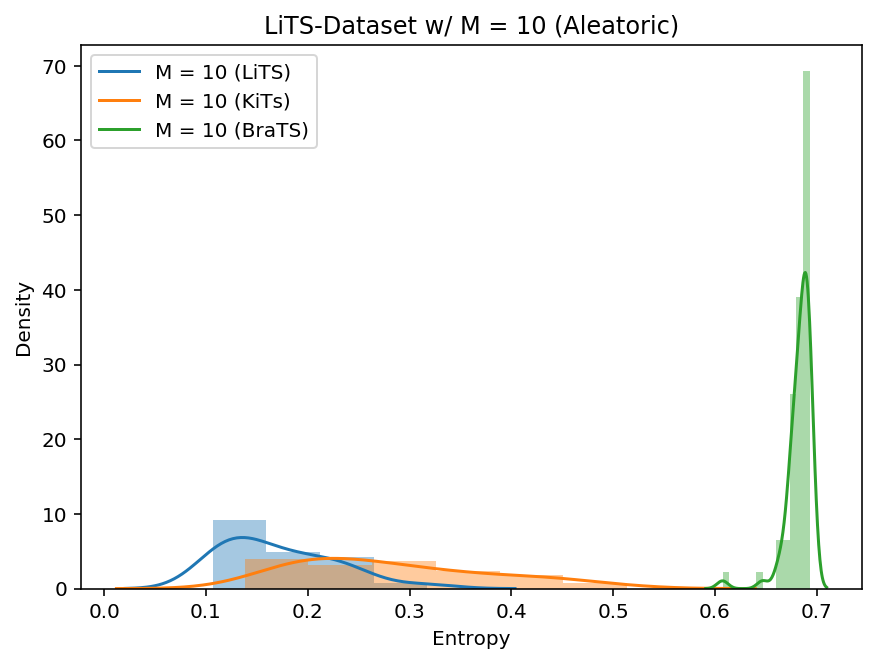

In [61]:
plot_results(lits_tta10, kits_tta10, brats_tta10, labels = ['M = 10 (LiTS)','M = 10 (KiTs)','M = 10 (BraTS)'], title = 'LiTS-Dataset w/ M = 10 (Aleatoric)')

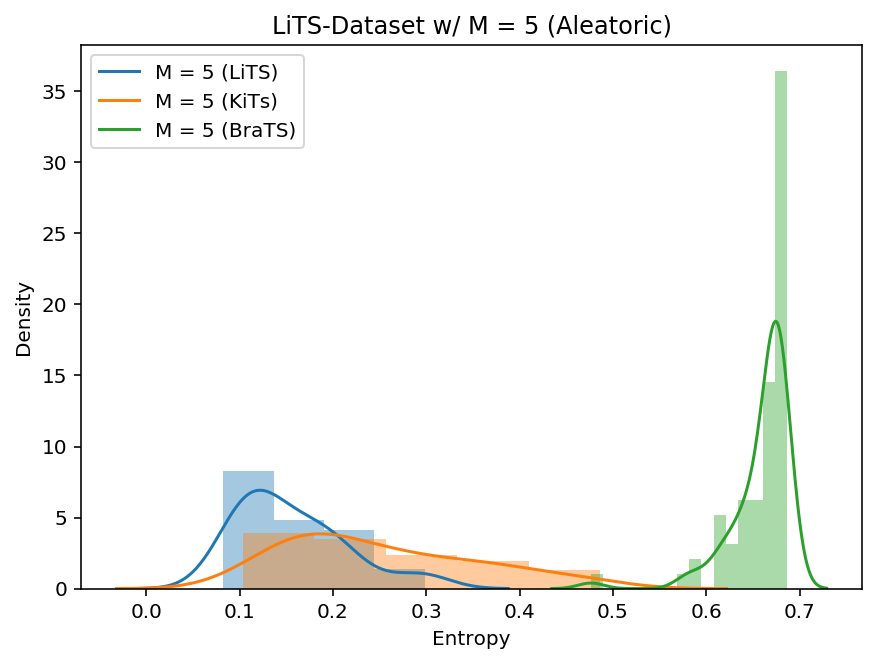

In [62]:
plot_results(lits_tta5, kits_tta5, brats_tta5, labels = ['M = 5 (LiTS)','M = 5 (KiTs)','M = 5 (BraTS)'], title = 'LiTS-Dataset w/ M = 5 (Aleatoric)')

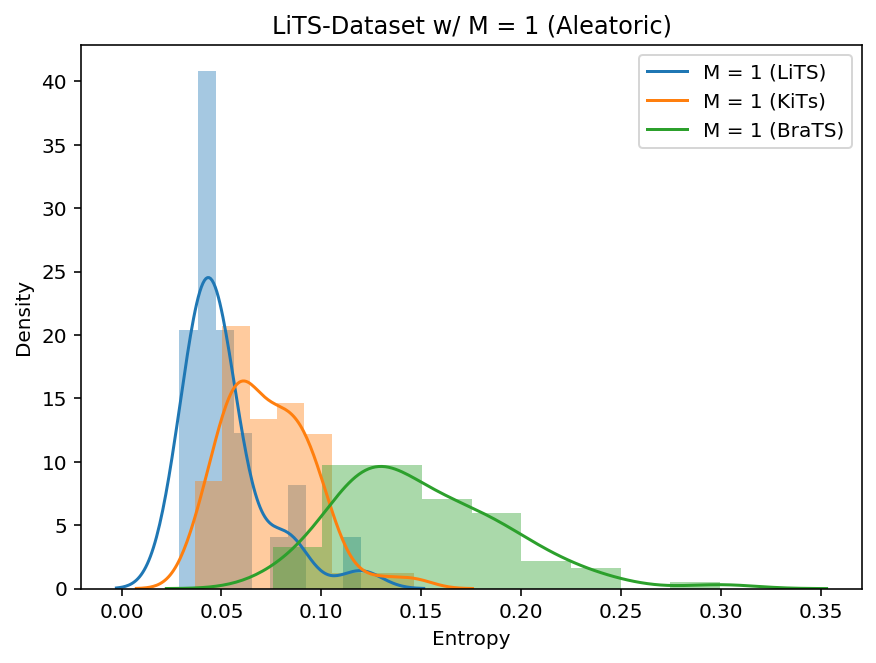

In [63]:
plot_results(lits_tta1, kits_tta1, brats_tta1, labels = ['M = 1 (LiTS)','M = 1 (KiTs)','M = 1 (BraTS)'], title = 'LiTS-Dataset w/ M = 1 (Aleatoric)')

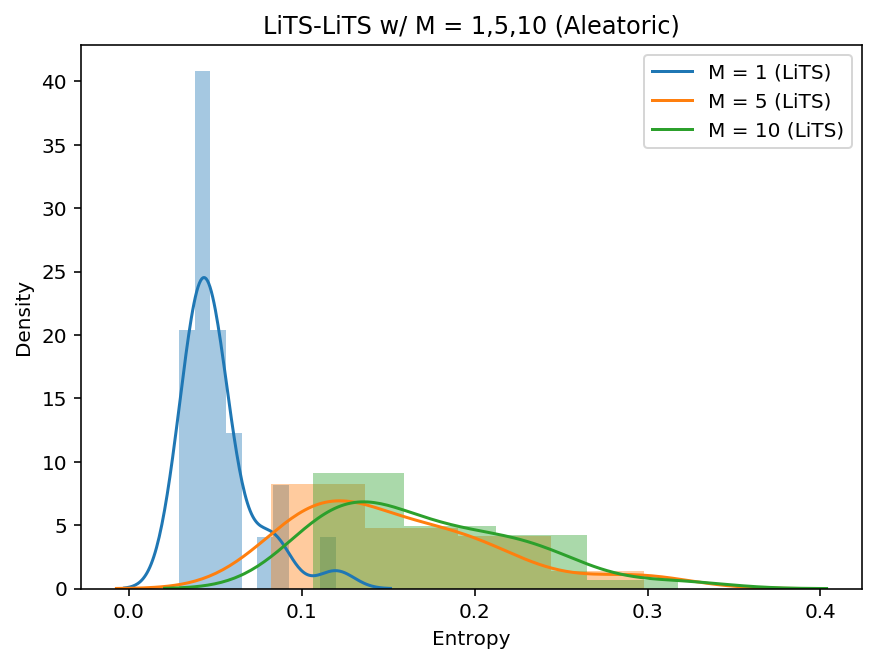

In [64]:
plot_results(lits_tta1, lits_tta5, lits_tta10, labels = ['M = 1 (LiTS)','M = 5 (LiTS)','M = 10 (LiTS)'], title = 'LiTS-LiTS w/ M = 1,5,10 (Aleatoric)')

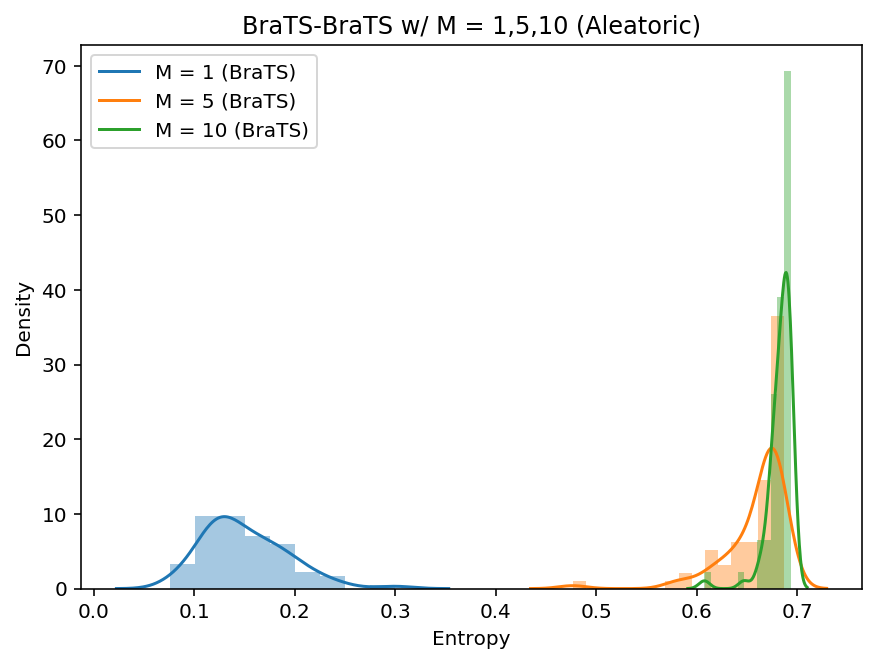

In [65]:
plot_results(brats_tta1, brats_tta5, brats_tta10, labels = ['M = 1 (BraTS)','M = 5 (BraTS)','M = 10 (BraTS)'], title = 'BraTS-BraTS w/ M = 1,5,10 (Aleatoric)')

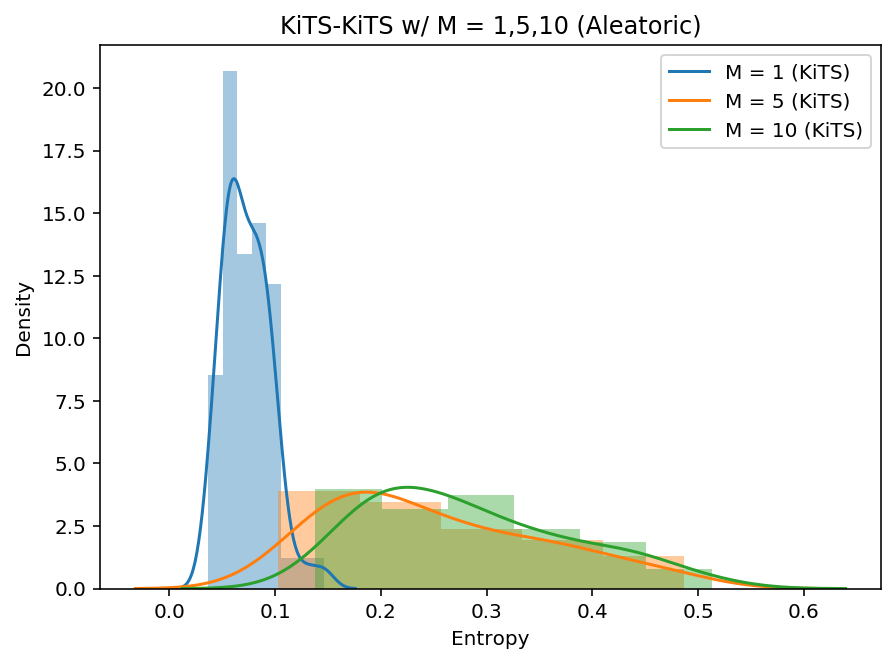

In [66]:
plot_results(kits_tta1, kits_tta5, kits_tta10, labels = ['M = 1 (KiTS)','M = 5 (KiTS)','M = 10 (KiTS)'], title = 'KiTS-KiTS w/ M = 1,5,10 (Aleatoric)')

In [ ]:
img

img_type
0 vol
1 seg
2 ent
3 overlay
4 pred
title

In [194]:
def plot_maps(imgs, img_types, titles, index_start = 0, index_end = None, step = 1):
    """ 
    
    """
    assert [len(imgs)]*2 == [len(img_types), len(titles)], "Arguments do not have same number of elements."
    for idx, img in enumerate(imgs):
        if isinstance(img, str):
            imgs[idx] = np.load(img)
        else:
            for sub_idx, sub_img in enumerate(img):
                imgs[idx][sub_idx] = np.load(sub_img)
    shape = imgs[0].shape
    for idx, img in enumerate(imgs):
        if isinstance(img, list):
            assert isinstance(img_types[idx], list), "Image and type mismatch."
            for sub_idx, element in enumerate(img):
                if img_types[idx][sub_idx] == 2:
                    assert shape == element[0,...].shape, "Invalid image shape."
                else:
                    assert shape == element.shape, "Invalid image shape."
        else:
            print(img.shape)
            if img_types[idx] == 2 or img_types[idx] == 4:
                assert shape == img[0,...].shape, "Invalid image shape."
            else:
                assert shape == img.shape, "Invalid image shape."
    save_dir = os.path.join(PNG_DIR,str(0+1).zfill(5))
    mkdir(save_dir)
    if index_end is None:
        index_end = shape[-1]
    for index in range(index_start, index_end, step):
        get_plot_maps(index, imgs, img_types, titles)

In [211]:
def get_plot_maps(img_index, imgs, img_types, titles, fig_width = 5):
    bounds=[0,1,2,3]
    filename = str(img_index+1).zfill(5)+'.png'
    save_dir = os.path.join(PNG_DIR,str(0+1).zfill(5))
    # Colormap for volume image.
    cmap = 'gray'
    # Custom colormap for segmentation map.
    seg_cmap = matplotlib.colors.ListedColormap(['black', 'white', 'red'])
    norm = matplotlib.colors.BoundaryNorm(bounds, seg_cmap.N)
    # Colormap for entropy map
    ent_cmap = 'viridis'
    # Custom colormap for overlay.
    overlay_cmap = matplotlib.colors.ListedColormap(['white', 'green', 'red'])
    norm = matplotlib.colors.BoundaryNorm(bounds, overlay_cmap.N)
    overlay_cmap.set_under(color="white", alpha=0.0)
    
    cmaps = [cmap, seg_cmap, ent_cmap, overlay_cmap, seg_cmap]
    
    # fig, axes = plt.subplots
    N = len(imgs)
    fig, axes = plt.subplots(nrows = 1, ncols = N, figsize = (fig_width, fig_width*N), constrained_layout=False)
    plt.subplots_adjust(right=3.0)
    
    def img_transform(img, img_index, img_type):
        if img_type == 2:
            return entropy(img[..., img_index], axis = 0)
        elif img_type == 4:
            return torch.argmax(torch.tensor(img[..., img_index]), dim = 0).numpy()
        else:
            return img[..., img_index]
    
    for idx, img in enumerate(imgs):
        axes[idx].title.set_text(titles[idx])
        if img_types[idx] == 2:
            im = axes[idx].imshow(img_transform(img, img_index, img_types[idx]), cmap = cmaps[img_types[idx]], interpolation='none')
            divider = make_axes_locatable(axes[idx])
            # cax = divider.append_axes('right', size='5%', pad=0.15)
            cax = divider.append_axes('right', size='5%', pad=0.15*20/fig_width)
            fig.colorbar(im, cax=cax, orientation='vertical')
        elif isinstance(img_types[idx], list):
            for sub_idx, sub_img in enumerate(img):
                axes[idx].imshow(img_transform(sub_img, sub_idx, img_types[idx][sub_idx]), cmap = cmaps[img_types[idx][sub_idx]], interpolation='none')
        else:    
            axes[idx].imshow(img_transform(img, img_index, img_types[idx]), cmap = cmaps[img_types[idx]], interpolation='none')
    plt.show()
    fig.savefig(os.path.join(save_dir,filename),bbox_inches="tight")
    plt.close()

In [212]:
vol = data_dict['brats20'][2]['vol']
seg = data_dict['brats20'][2]['seg']
tta = data_dict['brats20'][2]['tta'][2]
ttd = data_dict['brats20'][2]['tta'][2]

In [213]:
imgs = [vol,seg,[vol,seg],ttd,ttd,tta]
img_types = [0,1,[0,1],4,2,2]
titles = ['vol','seg','overlay','pred','ttd','tta']

(240, 240, 80)
(240, 240, 80)
(2, 240, 240, 80)
(2, 240, 240, 80)
(2, 240, 240, 80)


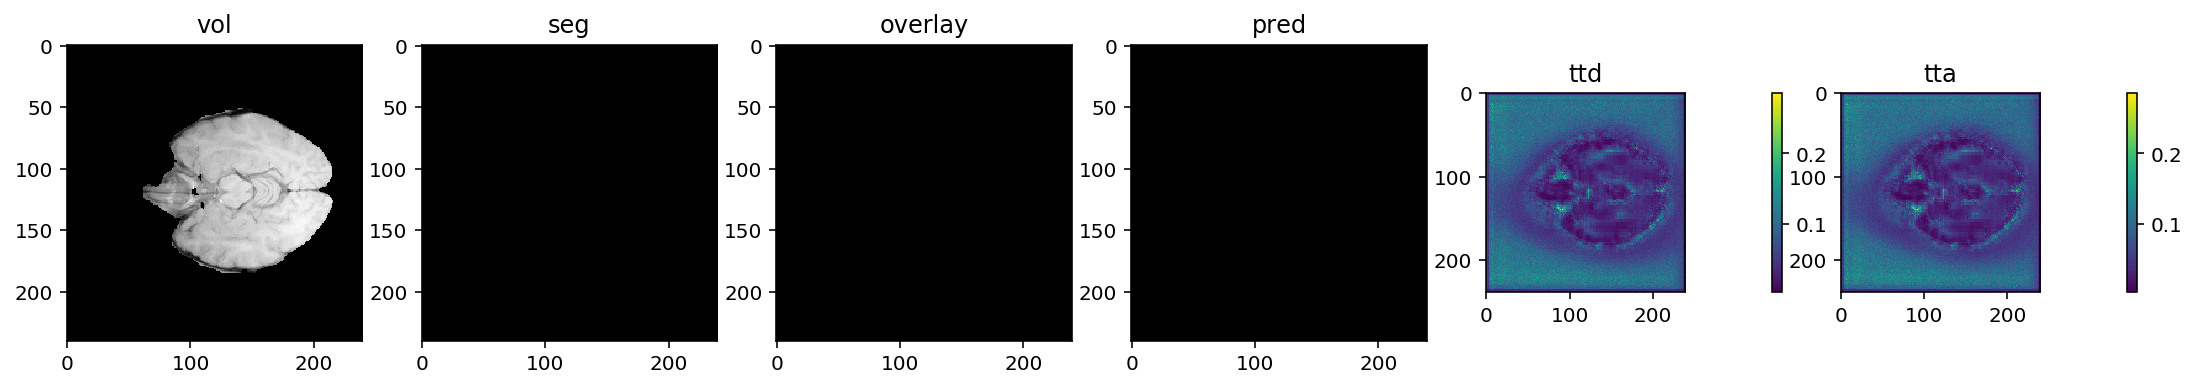

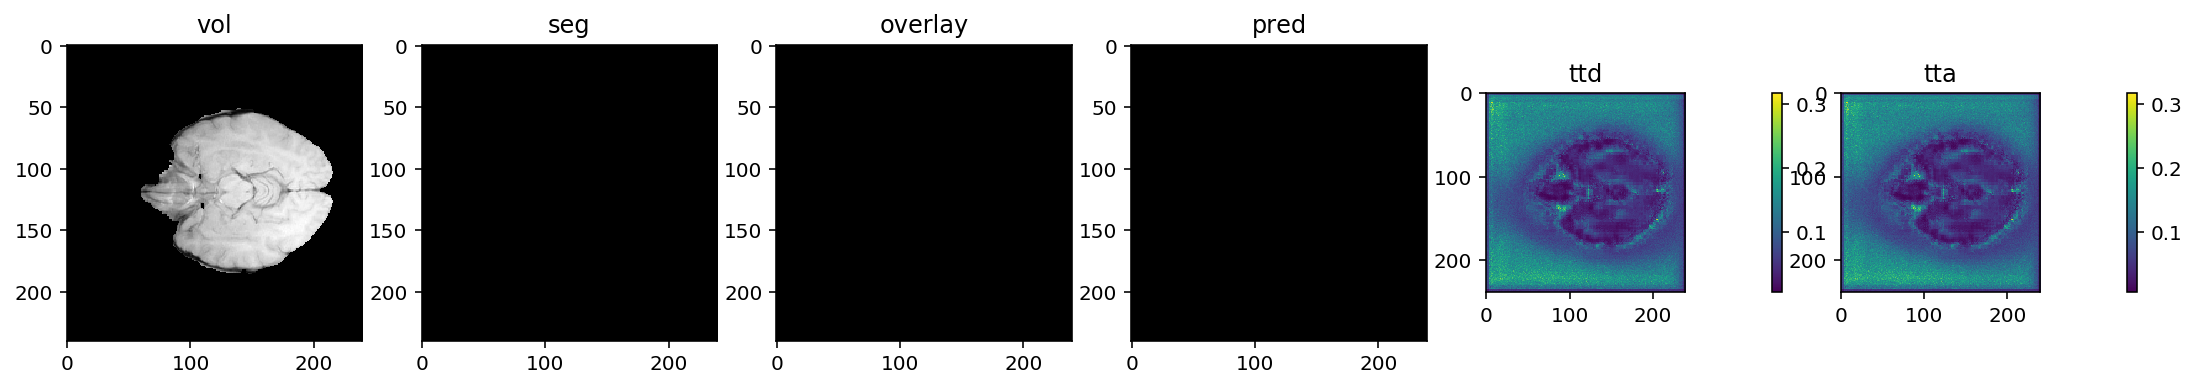

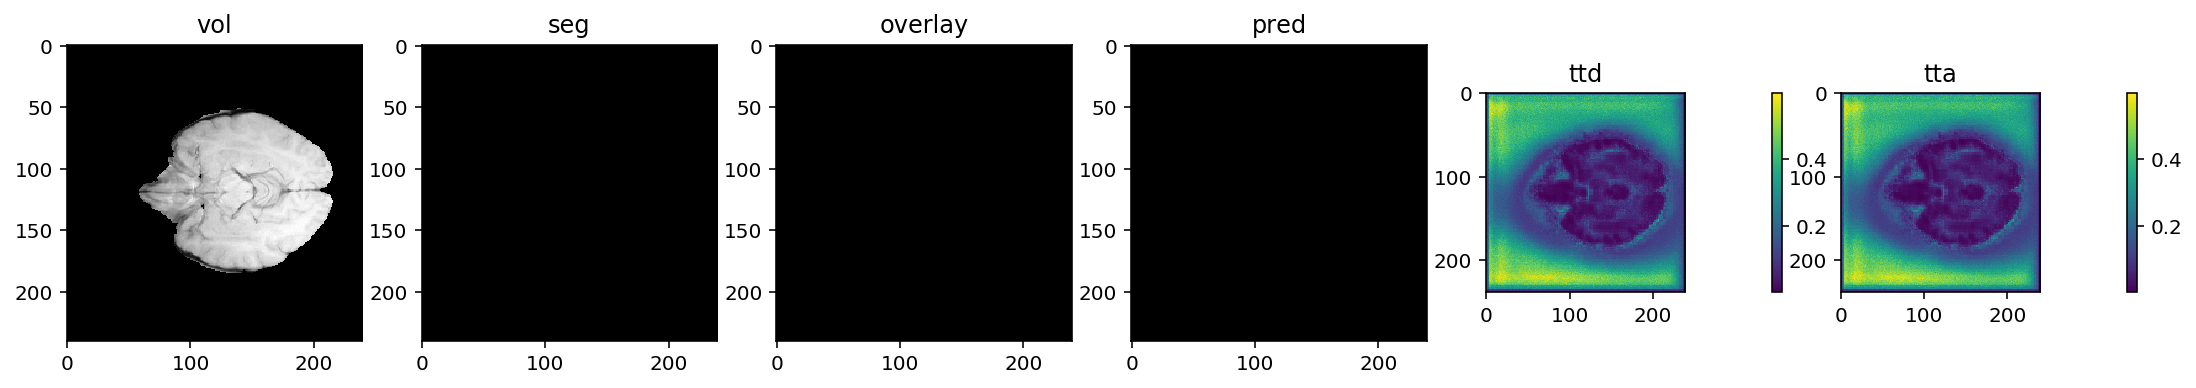

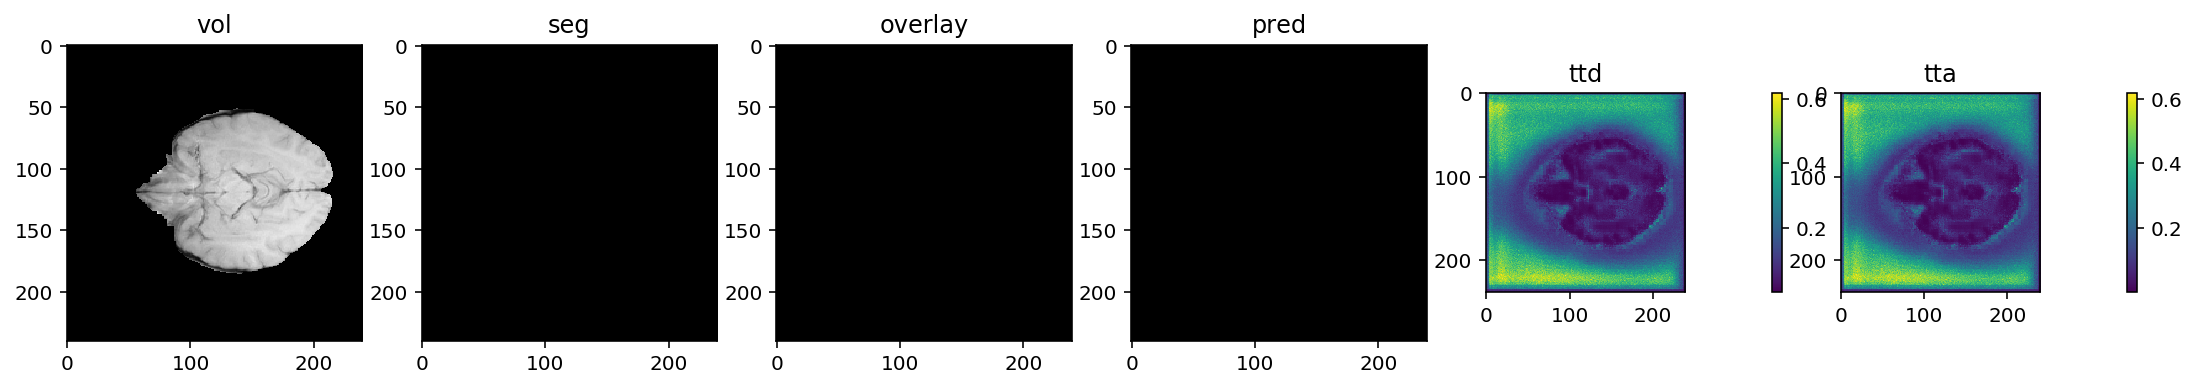

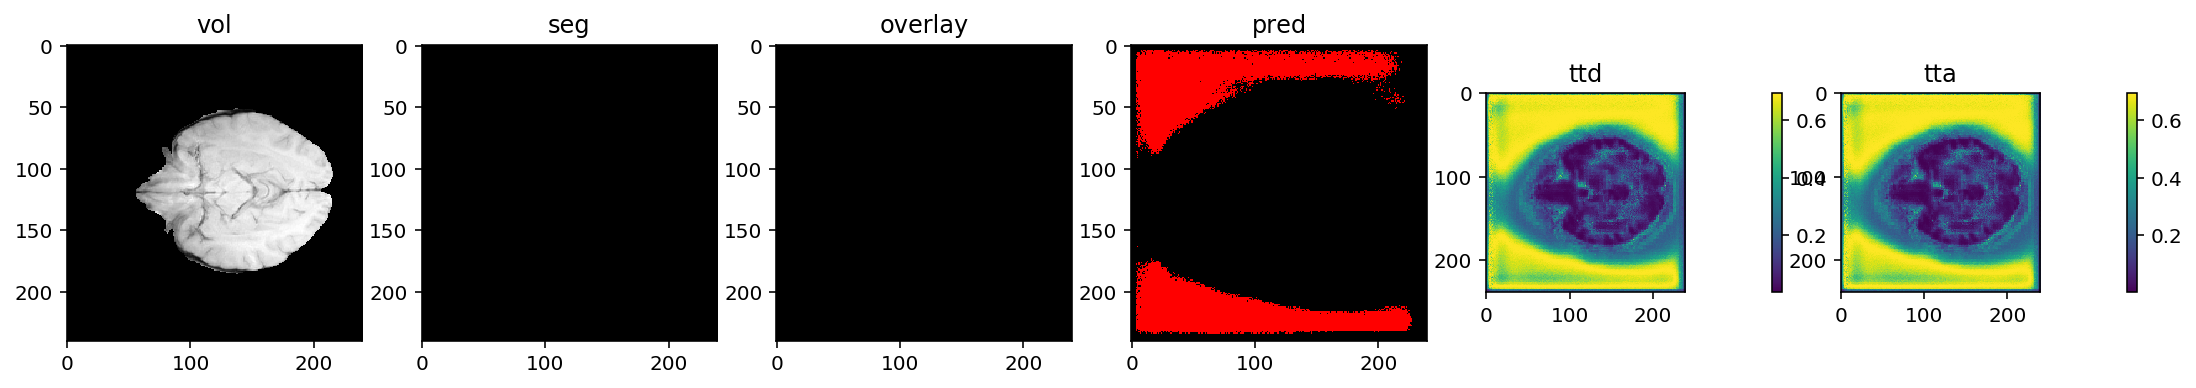

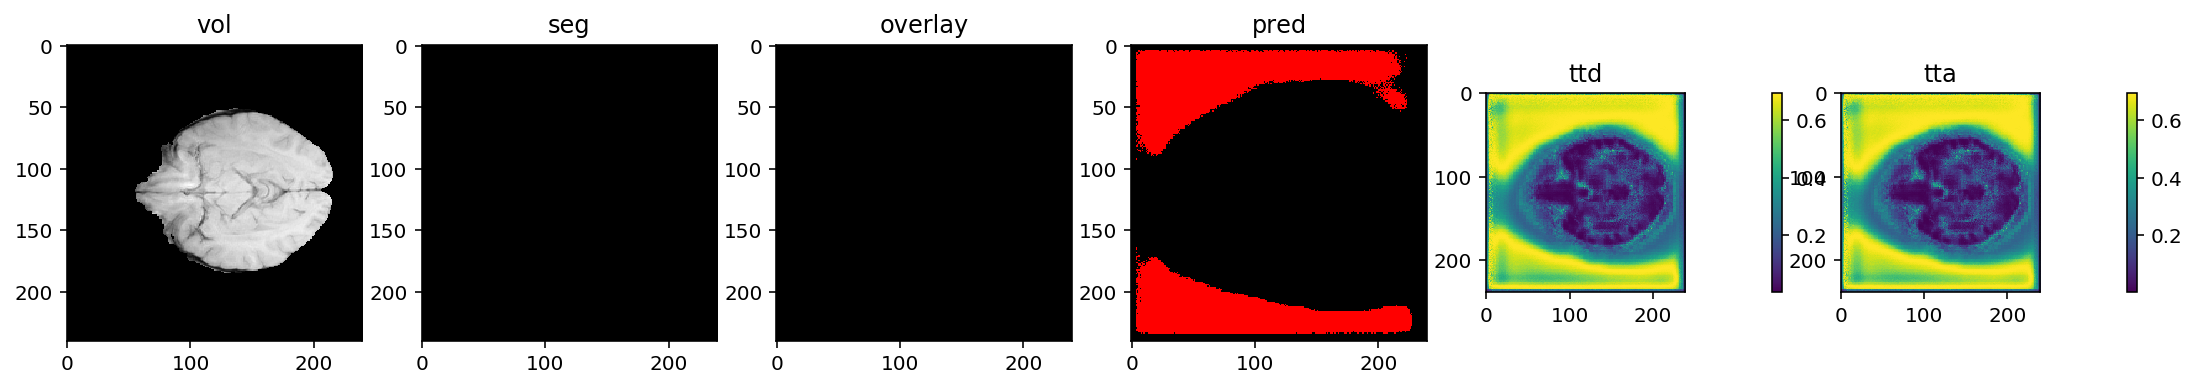

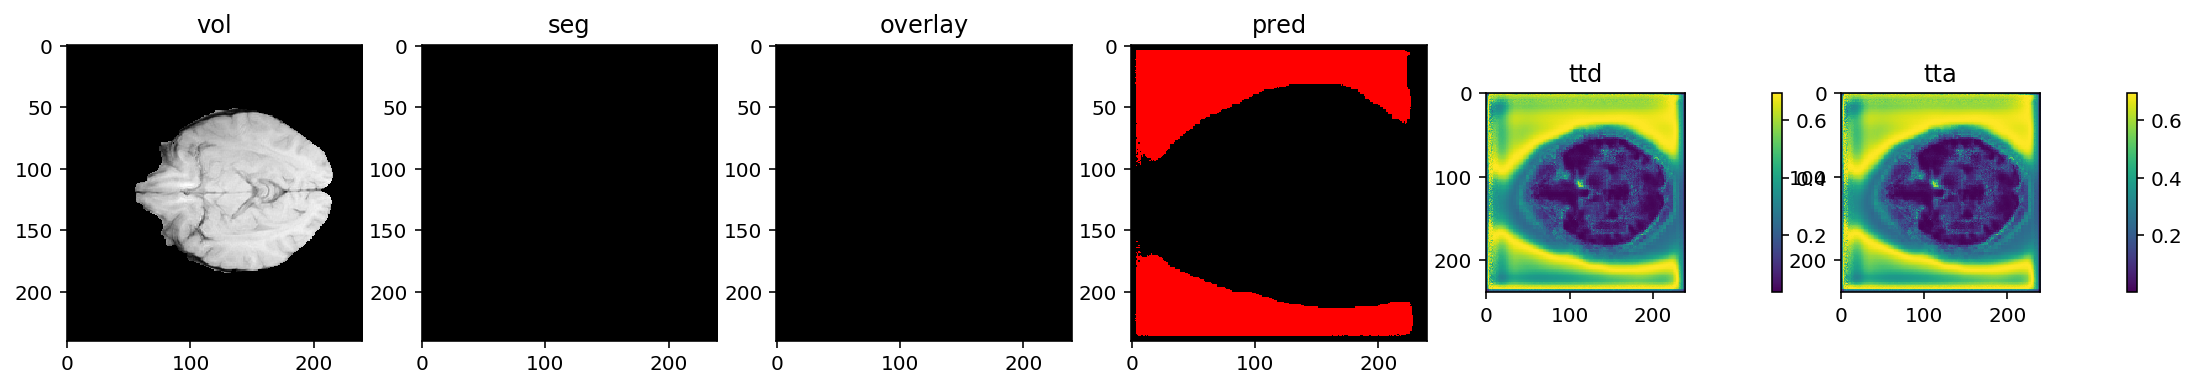

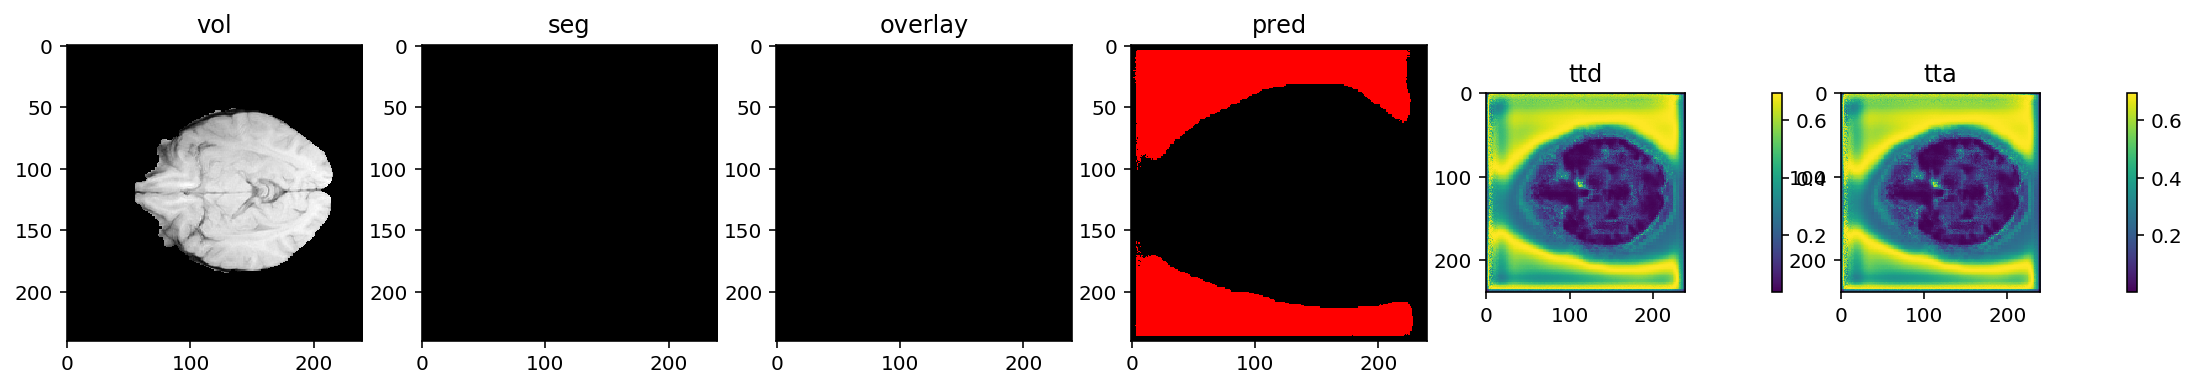

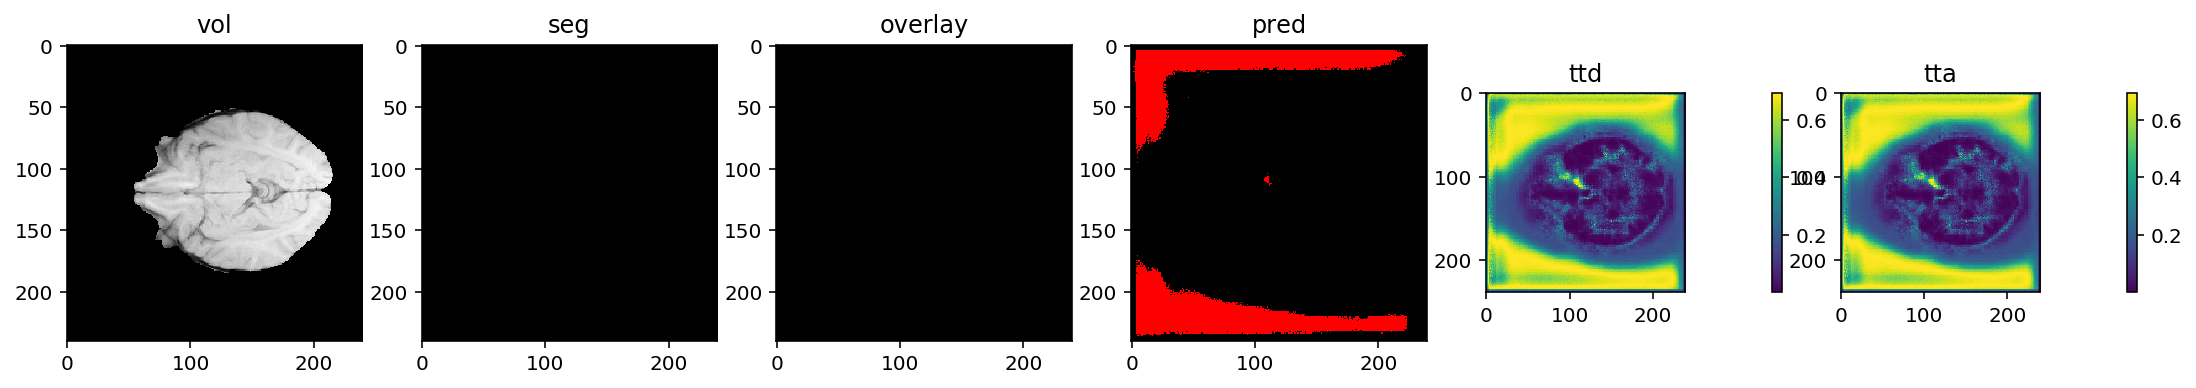

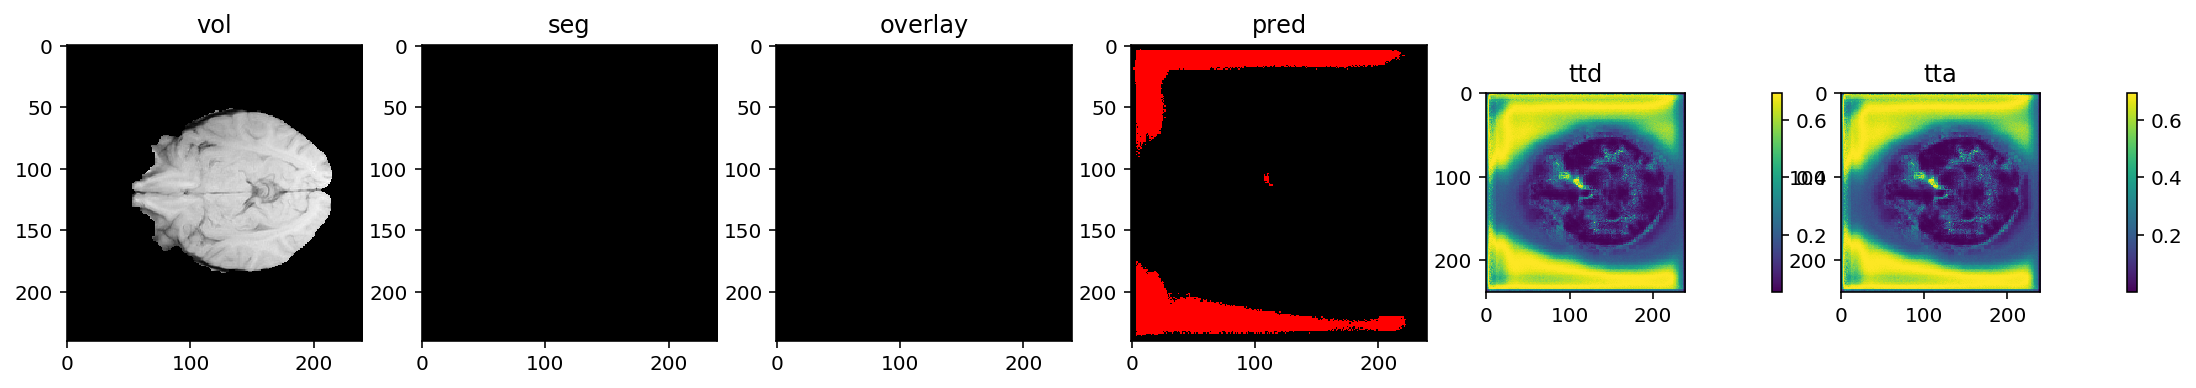

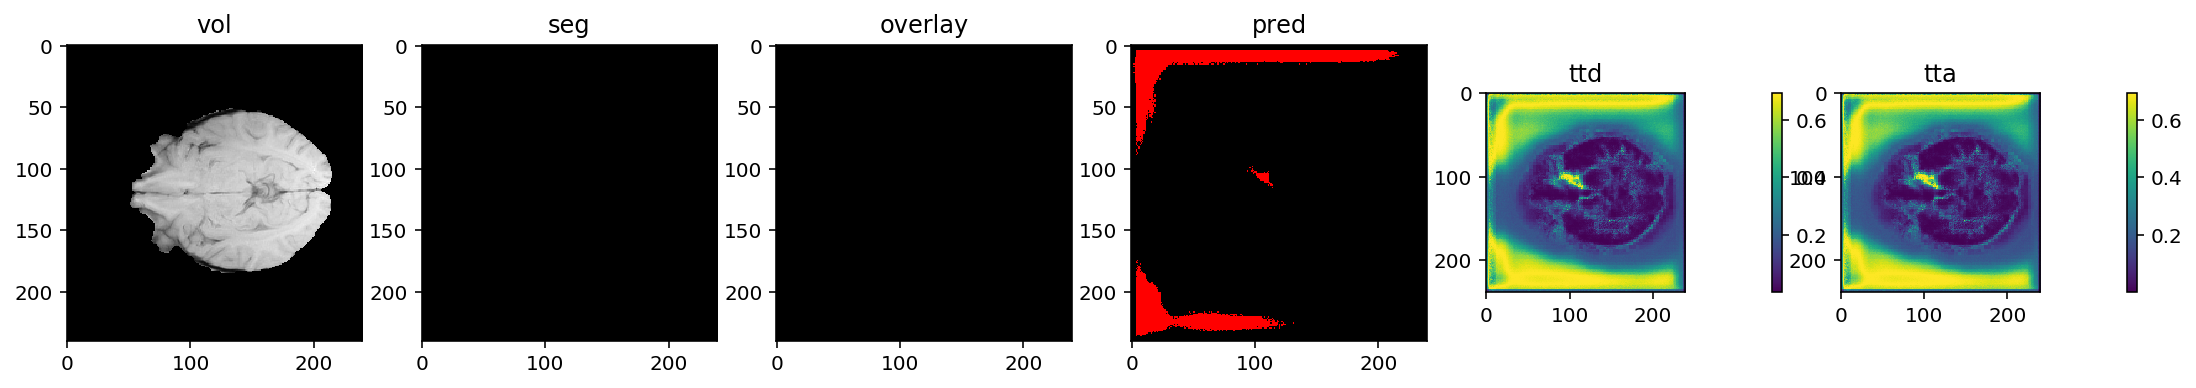

KeyboardInterrupt: 

In [214]:
plot_maps(imgs, img_types, titles)

In [77]:
dpi=200
plt.rc('figure', dpi=dpi)

In [146]:
'''
ood_entropy[dataset][unertainty][sample_index][N_avg]

- dataset (str) : {'brats','kits','lits'}
- unertainty (str) : {'ttd','tta'}
- sample_index (int) : [0,...,9]
- N_avg (int) : [1,...,10]
''';

'''
stats_dict[data_index][data_type][model_index]:
- data_index (int) : [0,...,9]
- data_type (str) : {'vol','seg','epis','alea''ttd','tta'} (ttd and tta are softmax values)
- model_index (int) : [0,...,9]
''';

In [67]:
for dataset in stats_dict.keys():
    if dataset == 'lits' or dataset =='kits':
        continue
    path = '/scratch/ec2684/cv/uq_maps/'
    cur_path = os.path.join(path,dataset+'_ensemble')
    mkdir(cur_path)
    key = list(stats_dict[dataset].keys())[0]
    num_data = len(stats_dict[dataset][key].keys())
    for i in tqdm(range(num_data)):
        vol = np.load(stats_dict[dataset]['vol'][i])
        seg = np.load(stats_dict[dataset]['seg'][i])
        alea = np.load(ood_ttd_tta[dataset]['tta'][i][10])
        epis = np.load(ood_ttd_tta[dataset]['ttd'][i][10])
        # alea = np.load(stats_dict[dataset]['tta'][i][10])
        # epis = np.load(stats_dict[dataset]['ttd'][i][10])
        alea_ent = entropy(alea, axis = 0)
        epis_ent = entropy(epis, axis = 0)
        alea_pred = torch.argmax(torch.tensor(alea), dim = 0)
        epis_pred = torch.argmax(torch.tensor(epis), dim = 0)
        folder = str(i+1).zfill(5)
        path = os.path.join(cur_path,folder)
        # print(path)
        mkdir(path)
        index_end = vol.shape[-1]
        for index in tqdm(range(0, index_end, 1)):
            plot_scan_and_masks(path, index, vol, seg, epis_ent, alea_ent, epis_pred, alea_pred)

In [ ]:

        # axes[1].title.set_text('Original Seg.')
        # axes[1].imshow(seg[...,index], cmap = seg_cmap, interpolation='none')
    
    axes[0].title.set_text('Original Overlay')
    axes[0].imshow(vol[..., index], cmap = cmap, interpolation='none')
    axes[0].imshow(seg[..., index], cmap = overlay_cmap, interpolation='none', alpha=0.35)
    
    output_mode = 'Model Output '
    
    e
        
    # axes[3].title.set_text('Epistemic')
    # im = axes[3].imshow(epis[..., index], cmap = epistemic_cmap, interpolation='none')
    # divider = make_axes_locatable(axes[3])
    # cax = divider.append_axes('right', size='5%', pad=0.15)
    # fig.colorbar(im, cax=cax, orientation='vertical')
    
    # axes[4].title.set_text('Aleatoric')
    # im = axes[4].imshow(alea[..., index], cmap = aleatoric_cmap, interpolation='none')
    # divider = make_axes_locatable(axes[4])
    # cax = divider.append_axes('right', size='5%', pad=0.15)
    # fig.colorbar(im, cax=cax, orientation='vertical')
    
    axes[1].title.set_text('Aleatoric')
    im = axes[1].imshow(alea[..., index], cmap = aleatoric_cmap, interpolation='none')
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes('right', size='5%', pad=0.15)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
#     axes[5].title.set_text('Hybrid (Epistemic+Aleatoric)')
#     im = axes[5].imshow(epis[..., index]+alea[..., index], cmap = superposition_cmap, interpolation='none')
#     divider = make_axes_locatable(axes[5])
#     cax = divider.append_axes('right', size='5%', pad=0.15)
#     fig.colorbar(im, cax=cax, orientation='vertical')
    
#     axes[6].title.set_text('Prediction (Epistemic)')
#     axes[6].imshow(pred_e[..., index], cmap = seg_cmap, interpolation='none')
        
    # axes[7].title.set_text('Prediction (Epistemic) Overlay')
    # axes[7].imshow(vol[..., index], cmap = cmap, interpolation='none')
    # axes[7].imshow(pred_e[..., index], cmap = overlay_cmap, interpolation='none', alpha=0.5)
    
    # axes[4].title.set_text('Prediction (Aleatoric)')
    # axes[4].imshow(pred_a[..., index], cmap = seg_cmap, interpolation='none')
    
    axes[2].title.set_text('Prediction (Aleatoric) Overlay')
    axes[2].imshow(vol[..., index], cmap = cmap, interpolation='none')
    axes[3].imshow(pred_a[..., index], cmap = overlay_cmap, interpolation='none', alpha=0.35)
    
    axes[3].title.set_text('Output (Hybrid+Prediction (Epistemic) ) Overlay')
    axes[3].imshow(epis[..., index]+alea[..., index], cmap = superposition_cmap, interpolation='none')
    axes[3].imshow(pred_e[..., index], cmap = overlay_cmap, interpolation='none', alpha=0.4)